In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

# EXPERIMENT SETS:
# - Calibration (no weighting): 01_18_24_All_Metrics
# - Only Foreground Loss: 01_21_24_Foreground_Calibrators
# - Balanced Loss: 01_21_24_Balanced_CE_Calibrators

log:
    root: /storage/vbutoi/scratch/ESE/inference
    load_pixel_meters: True 
    remove_shared_columns: True 
    drop_nan_metric_rows: True 
    min_fg_pixels: 100
    inference_paths:
        - "01_18_24_All_Metrics/WMH_Individual_Uncalibrated"
        - "01_18_24_All_Metrics/WMH_Individual_TempScaling"
        - "01_18_24_All_Metrics/WMH_Individual_VectorScaling"
        - "01_18_24_All_Metrics/WMH_Individual_DirichletScaling"
        - "01_18_24_All_Metrics/WMH_Individual_LTS"
        - "01_18_24_All_Metrics/WMH_Individual_NectarScaling"
        - "01_18_24_All_Metrics/WMH_Individual_ConstrainedNS"
        - "01_18_24_All_Metrics/WMH_Ensemble_Uncalibrated"
        - "01_18_24_All_Metrics/WMH_Ensemble_TempScaling"
        - "01_18_24_All_Metrics/WMH_Ensemble_VectorScaling"
        - "01_18_24_All_Metrics/WMH_Ensemble_DirichletScaling"
        - "01_18_24_All_Metrics/WMH_Ensemble_LTS"
        - "01_18_24_All_Metrics/WMH_Ensemble_NectarScaling"
        - "01_18_24_All_Metrics/WMH_Ensemble_ConstrainedNS"

        # - "01_21_24_Foreground_Calibrators/WMH_Individual_Uncalibrated"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_TempScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_VectorScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_DirichletScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_LTS"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_NectarScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Individual_ConstrainedNS"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_Uncalibrated"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_TempScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_VectorScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_DirichletScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_LTS"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_NectarScaling"
        # - "01_21_24_Foreground_Calibrators/WMH_Ensemble_ConstrainedNS"

        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_Uncalibrated"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_TempScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_VectorScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_DirichletScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_LTS"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_NectarScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Individual_ConstrainedNS"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_Uncalibrated"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_TempScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_VectorScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_DirichletScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_LTS"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_NectarScaling"
        # - "01_21_24_Balanced_CE_Calibrators/WMH_Ensemble_ConstrainedNS"
    
calibration:
    conf_interval:
        - 0.5
        - 1.
    num_bins: 10
    square_diff: False 
    neighborhood_width: 3

# cal_metrics:
#     - ECE:
#         _fn: ese.experiment.metrics.ece.ece_loss
#     - CW_ECE:
#         _fn: ese.experiment.metrics.ece.cw_ece_loss
#     - Edge_ECE:
#         _fn: ese.experiment.metrics.ece.edge_ece_loss
#     - ELM:
#         _fn: ese.experiment.metrics.elm.elm_loss
#     - Foreground_ECE:
#         _fn: ese.experiment.metrics.ece.ece_loss
#         ignore_index: 0
#     - Foreground_CW_ECE:
#         _fn: ese.experiment.metrics.ece.cw_ece_loss
#         ignore_index: 0
#     - Foreground_Edge_ECE:
#         _fn: ese.experiment.metrics.ece.edge_ece_loss
#         ignore_index: 0       
#     - Foreground_ELM:
#         _fn: ese.experiment.metrics.elm.elm_loss
#         ignore_index: 0

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.inference import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg
)

Dropping rows with NaN metric score. Dropped from 160524 -> 160519 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                               log_set                                              
/storage/vbutoi/scratch/ESE/inference/01_21_24_Foreground_Calibrators/WMH_Ensemble_ConstrainedNS       20240122_223914-0KRP-efe28aa61d20e01097d309e00095d153    5880
                                                                                                       20240122_223918-KIPL-47cab462e44676b868712f1a5ebbcd59    5880
/storage/vbutoi/scratch/ESE/inference/01_21_24_Foreground_Calibrators/WMH_Ensemble_DirichletScaling    20240121_204347-ZFCG-010b6351ac41abec9e24ef71dfbb0408    5880
                                                                                                       20240121_204351-YCZ4-0fb1ebd6b1636fd7660e1a34952f219d    5880
/storage/vbutoi/scratch/ESE/inference/01_21_24_Foreground_Calib

## Let's try to see if there is any hope with having better ECE/ELM makes better ensembles. Note that this isn't a conclusive result just because the number of samples per images that are used to calculate ECE/ELM are not sufficient to get actual statistical quantities.

### We have to add to each row a column that is the difference betweeen the row's metric_score and the metric_score corresponding to the same image metric as mean uncalibrated UNet performance. 

In [4]:
# Step 1: Get the rows corresponding to a unet aveages across multiple seeds with no calibration.
average_unet_row = image_info_df[(image_info_df['pretrained_seed'] == 'Average') & (image_info_df['calibrator'] == 'Uncalibrated')]

In [5]:
unique_datapoint_cols = ['data_id', 'slice_idx', 'image_metric', 'groupavg_image_metric']

In [6]:
# Sanity check that for each datapoint we only have one average unet row.
num_avg_unets_per_datapoint = average_unet_row.groupby(unique_datapoint_cols).size()
assert num_avg_unets_per_datapoint.max() == 1,\
    f"There should be only one row for each data_id, slice_idx, image_metric, and groupavg image metric combination, got {num_avg_unets_per_datapoint}."

In [7]:
# Make sure there are no NaNs in the average UNet rows.
assert average_unet_row['metric_score'].isna().sum() == 0, "There should be no NaNs in metric_score of UNet rows."
assert average_unet_row['groupavg_metric_score'].isna().sum() == 0, "There should be no NaNs in groupavg_metric_score of UNet rows."

In [8]:
# Step 2: Merge based on 'image_metric', 'subject_id', and 'slice_idx'
info_df_w_avg_unet_cols = pd.merge(
    image_info_df, 
    average_unet_row[unique_datapoint_cols + ['metric_score', 'groupavg_metric_score']], 
    on=unique_datapoint_cols, 
    how='left', 
    suffixes=('', '_average_unet')
    )

In [9]:
# Step 3: Calculate the difference
info_df_w_avg_unet_cols['metric_delta'] = info_df_w_avg_unet_cols['metric_score'] - info_df_w_avg_unet_cols['metric_score_average_unet'] # Current - Baseline
info_df_w_avg_unet_cols['groupavg_metric_delta'] = info_df_w_avg_unet_cols['groupavg_metric_score'] - info_df_w_avg_unet_cols['groupavg_metric_score_average_unet'] # Current - Baseline
# Drop those columns
info_df_w_delta = info_df_w_avg_unet_cols.drop(columns=['metric_score_average_unet', 'groupavg_metric_score_average_unet'])

## Now we can look at trends! We want to make some scatterplots to look at relationships between calibration scores and their relative improvement over the baseline.   

In [10]:
# First, we want only the rows corresponding to group metrics, no longer looking at seeds.
grouped_models_df = info_df_w_delta[info_df_w_delta['model_type'] == 'group'].reset_index(drop=True)

In [11]:
# SANITY CHECKS, MAKE SURE THAT FOR CALIBRATORS UNCALIBRATED, TEMPERATURE_SCALING, LTS
for calibrator in ["Uncalibrated", "Temperature_Scaling", "LTS"]:
    unique_qual_metrics = grouped_models_df[grouped_models_df['metric_type'] == 'quality']['image_metric'].unique()
    for quality_metric in unique_qual_metrics:
        # Checkign that the delta is 0 for the calibrator and the quality_metric
        rows = grouped_models_df[
            (grouped_models_df['calibrator'] == calibrator) & 
            (grouped_models_df['image_metric'] == quality_metric) &
            (grouped_models_df['method_name'] == 'UNet (seed=Average)')
        ]
        assert (rows['metric_delta'] == 0).all(),\
            f"Delta from base should be 0 for the calibrator {calibrator} and the quality metric {quality_metric}, got {rows['metric_delta']}."

In [12]:
# Make a bunch of new rows where the image_metric is the groupavg_image_metric and the metric_score is the groupavg_metric_score and the metric_delta is the groupavg_metric_delta
groupavg_rows = grouped_models_df.copy()
groupavg_rows['image_metric'] = groupavg_rows['groupavg_image_metric']
groupavg_rows['metric_score'] = groupavg_rows['groupavg_metric_score']
groupavg_rows['metric_delta'] = groupavg_rows['groupavg_metric_delta']
# Drop the groupavg columns
standard_image_rows = grouped_models_df.drop(columns=['groupavg_image_metric', 'groupavg_metric_score', 'groupavg_metric_delta']) 
groupavg_rows = groupavg_rows.drop(columns=['groupavg_image_metric', 'groupavg_metric_score', 'groupavg_metric_delta'])
# Concatenate the two
grouped_models_df = pd.concat([standard_image_rows, groupavg_rows], axis=0, ignore_index=True)

In [13]:
# Create a pivot table with 'metric_type' as columns
pivot_grouped_models_df = grouped_models_df.pivot_table(
    index=['configuration', 'method_name', 'calibrator', 'data_id', 'slice_idx'],
    values=['metric_score', 'metric_delta'], 
    columns=['metric_type', 'image_metric'], 
    aggfunc='mean'
).reset_index()

In [14]:
# Make a copy so that we can modify the column names
pivot_perf_per_datpoint = pivot_grouped_models_df.copy()
# Make new column names.
new_cols = []
for col in pivot_grouped_models_df.columns.values:
    if col[0] == 'metric_delta':
        new_cols.append(f'delta_{col[-1]}')
    elif col[-1] == '':
        new_cols.append(col[0])
    else:
        new_cols.append(col[-1])
# Set the column names to be the lowest non empty level per column in the multi-index
pivot_perf_per_datpoint.columns = new_cols

In [15]:
# We want to sort the pivot_df. 
method_order_name = ['UNet (seed=Average)', 'Ensemble (mean, logits)', 'Ensemble (mean, probs)']
calibrator_order_name = ['Uncalibrated', 'Temperature_Scaling', 'Vector_Scaling', 'Dirichlet_Scaling', 'LTS', 'NECTAR_Scaling', 'Constrained_NS']
# Sort the methods
pivot_perf_per_datpoint['method_name'] = pivot_perf_per_datpoint['method_name'].astype('category')
pivot_perf_per_datpoint['method_name'] = pivot_perf_per_datpoint['method_name'].cat.reorder_categories(method_order_name)
# Sort the calibrators
pivot_perf_per_datpoint['calibrator'] = pivot_perf_per_datpoint['calibrator'].astype('category')
pivot_perf_per_datpoint['calibrator'] = pivot_perf_per_datpoint['calibrator'].cat.reorder_categories(calibrator_order_name)
# Sort the dataframe
sorted_perf_df = pivot_perf_per_datpoint.sort_values(by=['method_name', 'calibrator'])

## Looking at change in *predicted ensemble* calibration vs change in Dice.

In [16]:
# Assert that each subplot will have the same number of datapoints on it.
num_per_config = sorted_perf_df.groupby(['method_name', 'calibrator']).size()
assert len(num_per_config.unique()) == 1,\
    f"Each subplot should have the same number of datapoints on it, got {num_per_config}."

In [17]:
num_per_config

method_name              calibrator         
UNet (seed=Average)      Uncalibrated           273
                         Temperature_Scaling    273
                         Vector_Scaling         273
                         Dirichlet_Scaling      273
                         LTS                    273
                         NECTAR_Scaling         273
                         Constrained_NS         273
Ensemble (mean, logits)  Uncalibrated           273
                         Temperature_Scaling    273
                         Vector_Scaling         273
                         Dirichlet_Scaling      273
                         LTS                    273
                         NECTAR_Scaling         273
                         Constrained_NS         273
Ensemble (mean, probs)   Uncalibrated           273
                         Temperature_Scaling    273
                         Vector_Scaling         273
                         Dirichlet_Scaling      273
                   

In [18]:
from ese.experiment.analysis.plot_utils import plot_method_vs_calibrator_scatterplots, clump_df_datapoints

In [19]:
sorted_perf_df.keys()

Index(['configuration', 'method_name', 'calibrator', 'data_id', 'slice_idx',
       'delta_GroupAvg_Image_CW-ECE', 'delta_GroupAvg_Image_ECE',
       'delta_GroupAvg_Image_ELM', 'delta_GroupAvg_Image_Edge-ECE',
       'delta_GroupAvg_Image_Edge-ELM',
       'delta_GroupAvg_Image_Foreground-CW-ECE',
       'delta_GroupAvg_Image_Foreground-ECE',
       'delta_GroupAvg_Image_Foreground-ELM',
       'delta_GroupAvg_Image_Foreground-Edge-ECE',
       'delta_GroupAvg_Image_Foreground-Edge-ELM', 'delta_Image_CW-ECE',
       'delta_Image_ECE', 'delta_Image_ELM', 'delta_Image_Edge-ECE',
       'delta_Image_Edge-ELM', 'delta_Image_Foreground-CW-ECE',
       'delta_Image_Foreground-ECE', 'delta_Image_Foreground-ELM',
       'delta_Image_Foreground-Edge-ECE', 'delta_Image_Foreground-Edge-ELM',
       'delta_Dice', 'delta_GroupAvg_Dice', 'delta_GroupAvg_HD95',
       'delta_HD95', 'GroupAvg_Image_CW-ECE', 'GroupAvg_Image_ECE',
       'GroupAvg_Image_ELM', 'GroupAvg_Image_Edge-ECE',
       'GroupAvg

In [20]:
# for foreground_option in ['', 'Foreground-']:
#     for group_option in ['', 'GroupAvg_']:
#         x_metric_name = f'delta_{group_option}Image_{foreground_option}Edge-ECE'
#         y_metric_name = f'delta_Dice'
#         # Plot the relationship between the two metrics
#         plot_method_vs_calibrator_scatterplots(
#             df=sorted_perf_df, 
#             x=x_metric_name, 
#             y=y_metric_name,
#             sharex=False,
#             sharey=False,
#             height=5
#         )
#         break
#     break

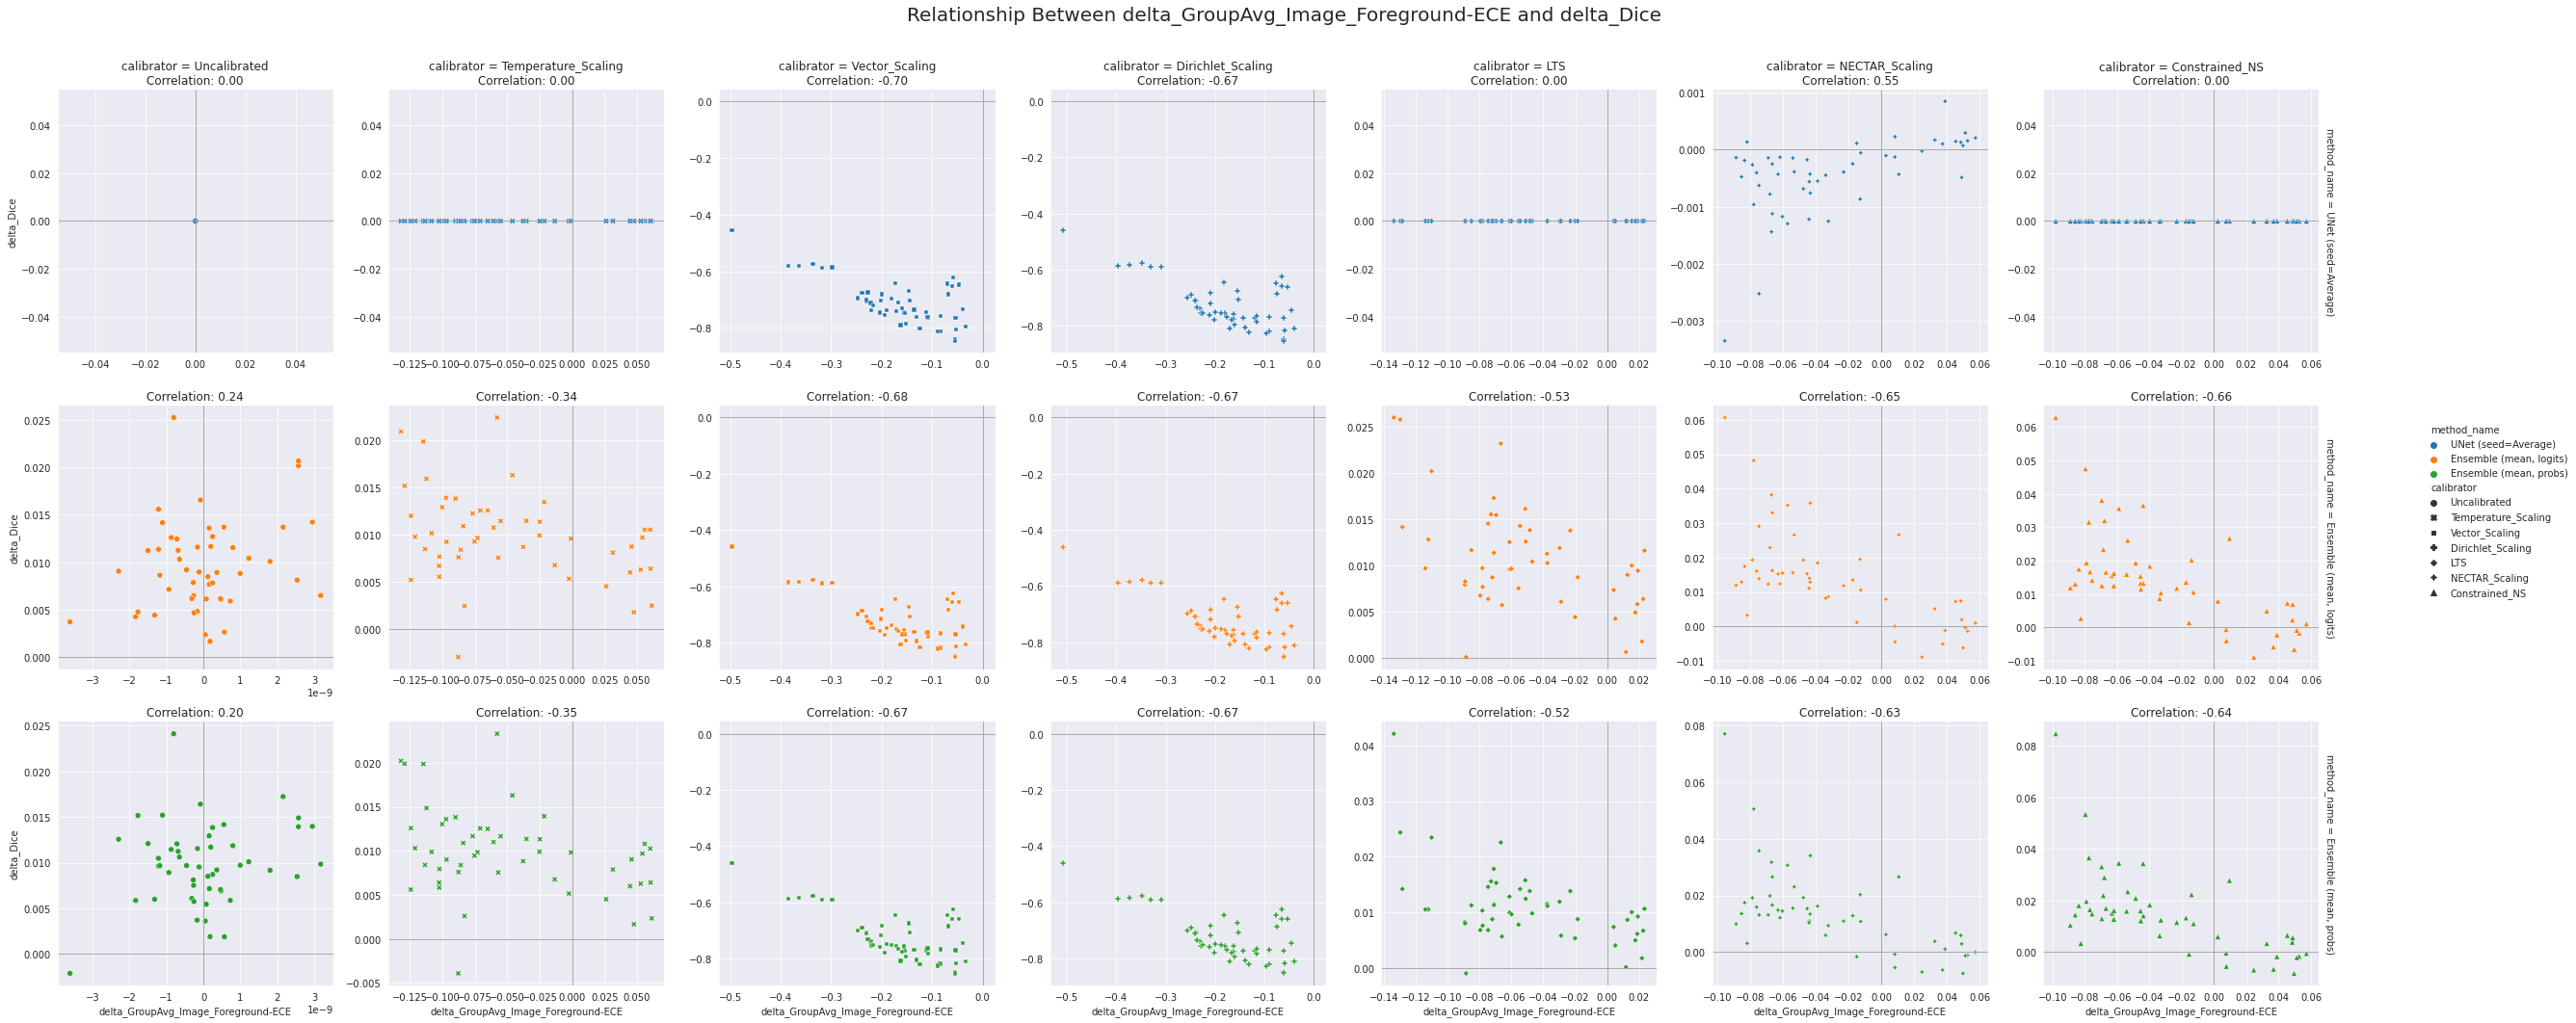

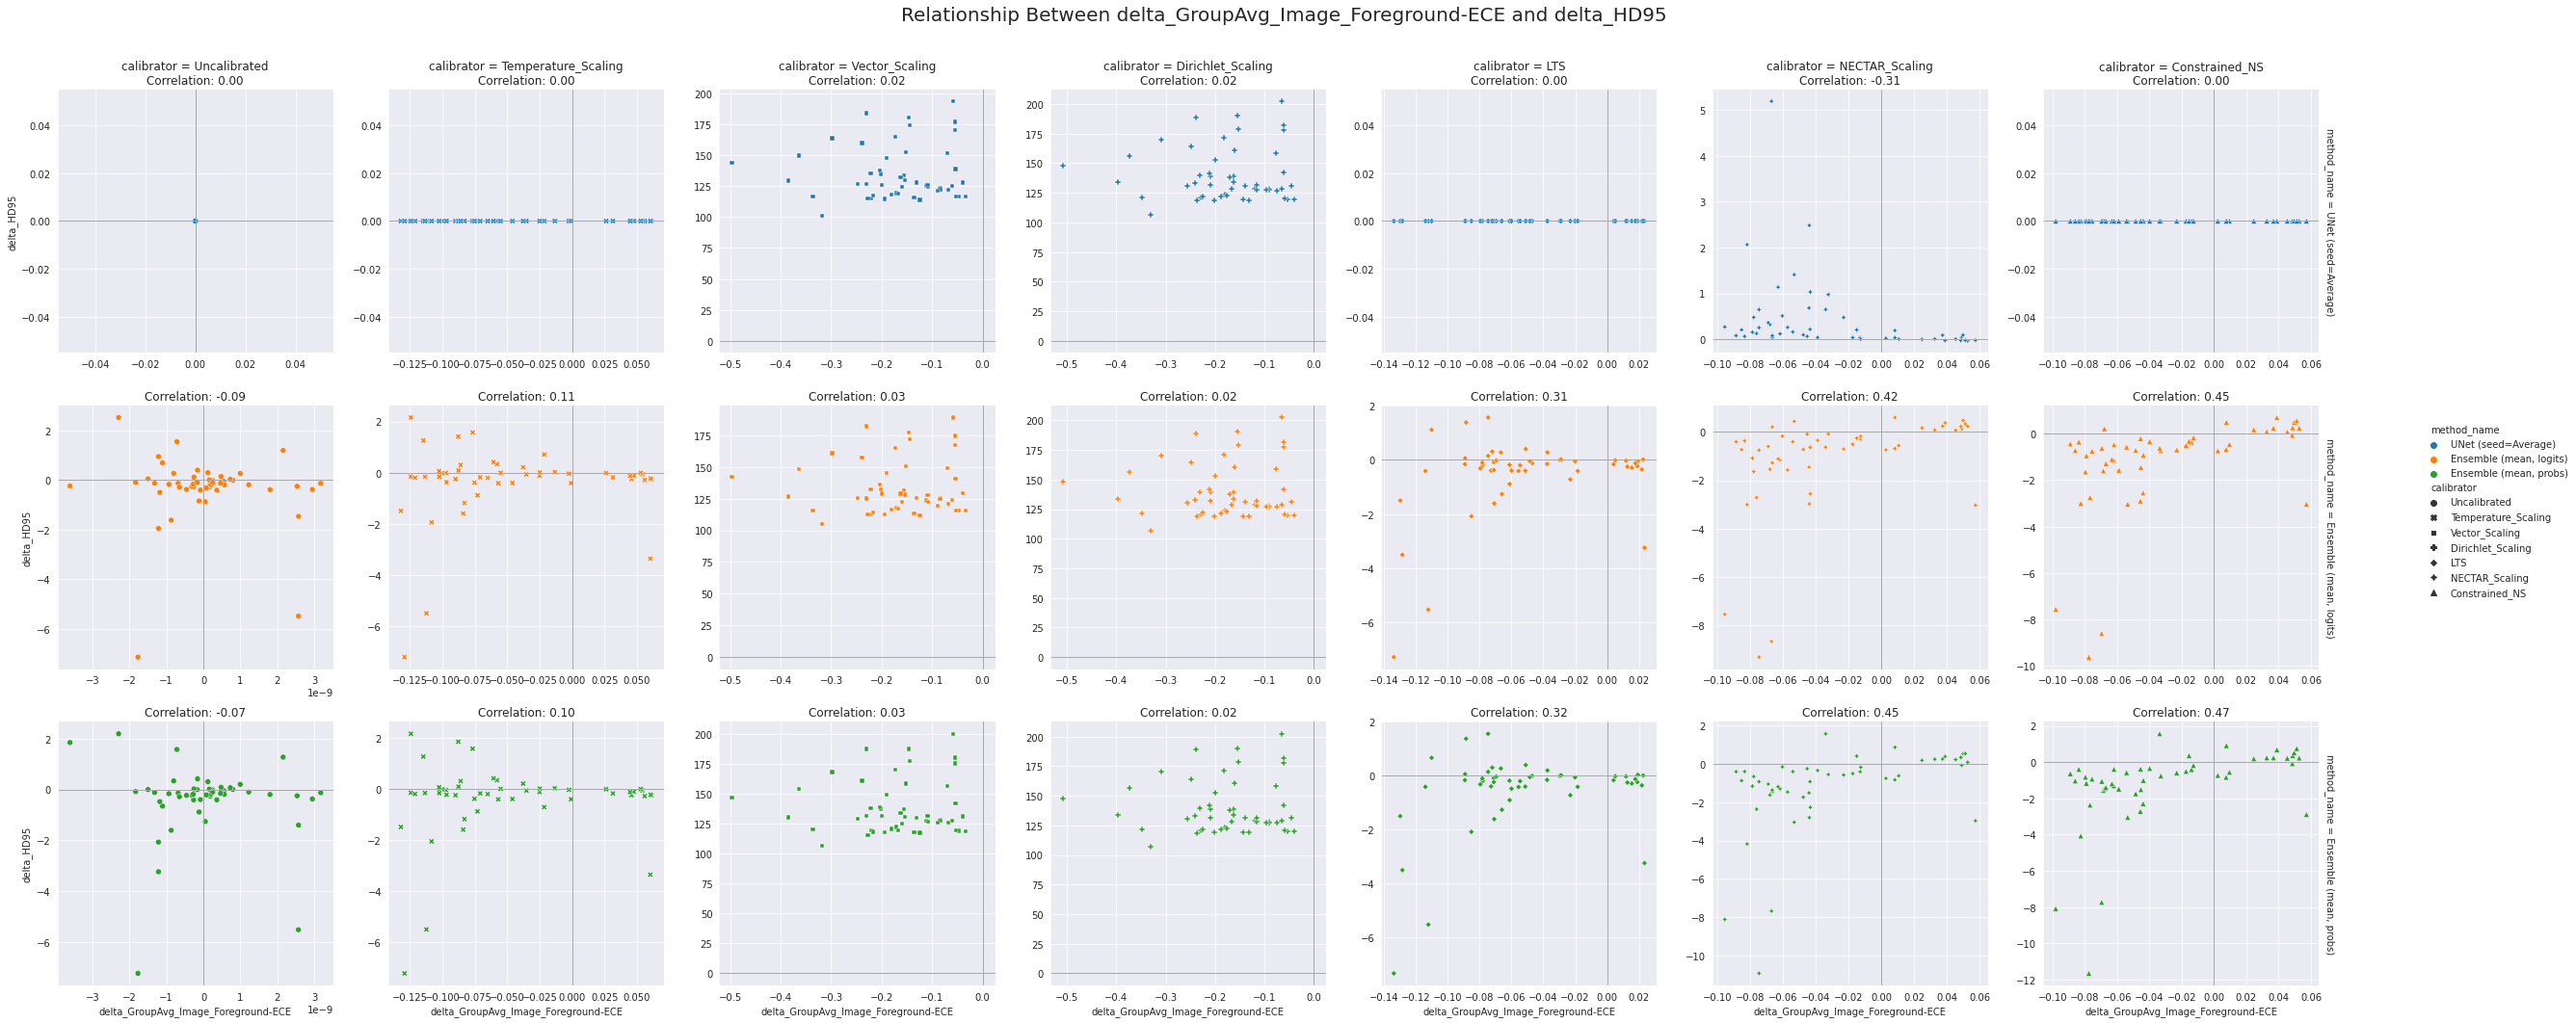

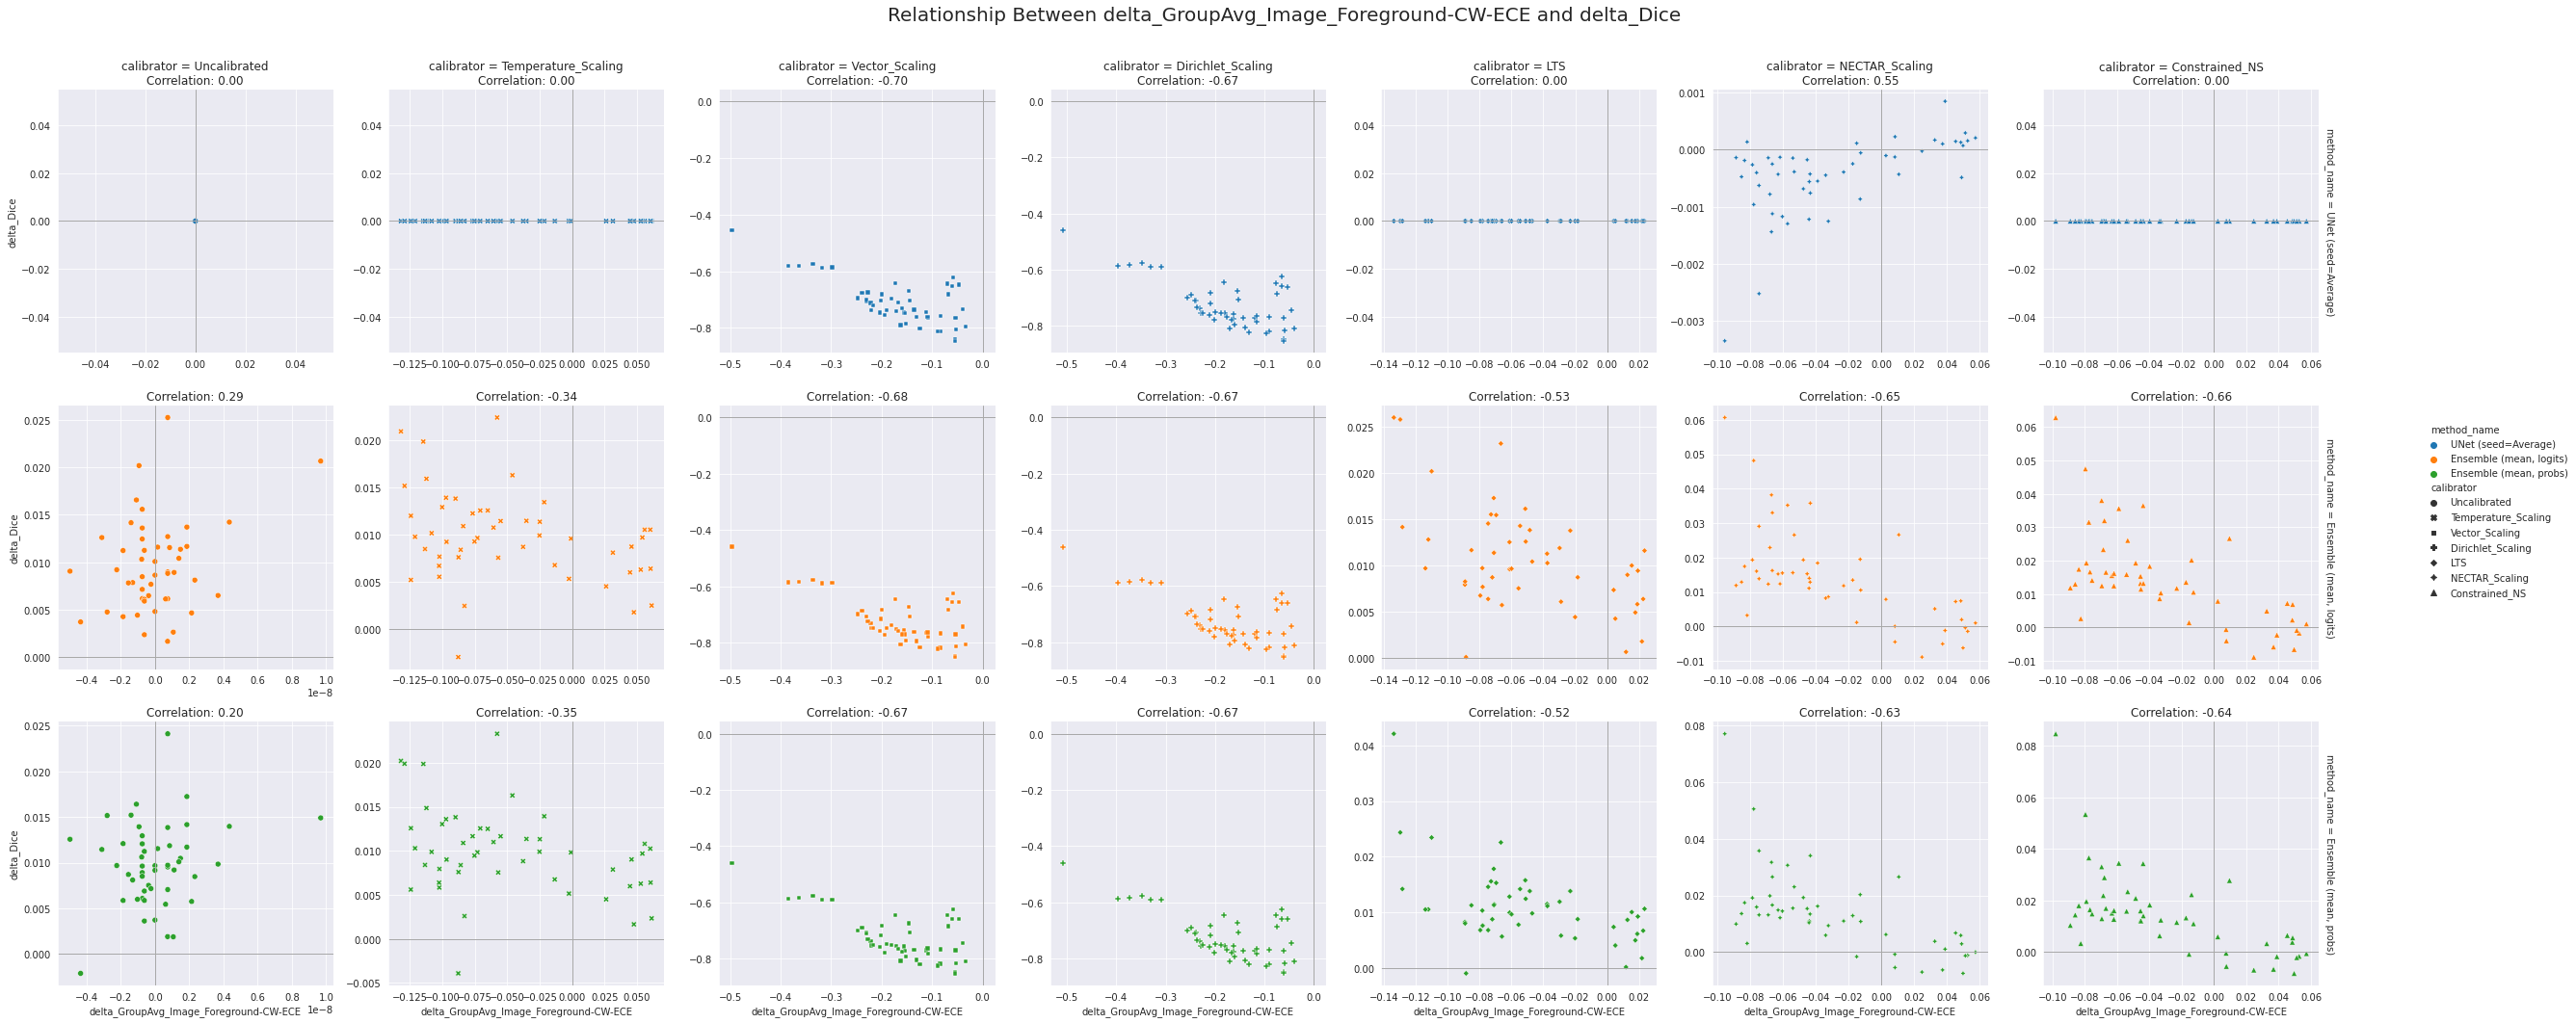

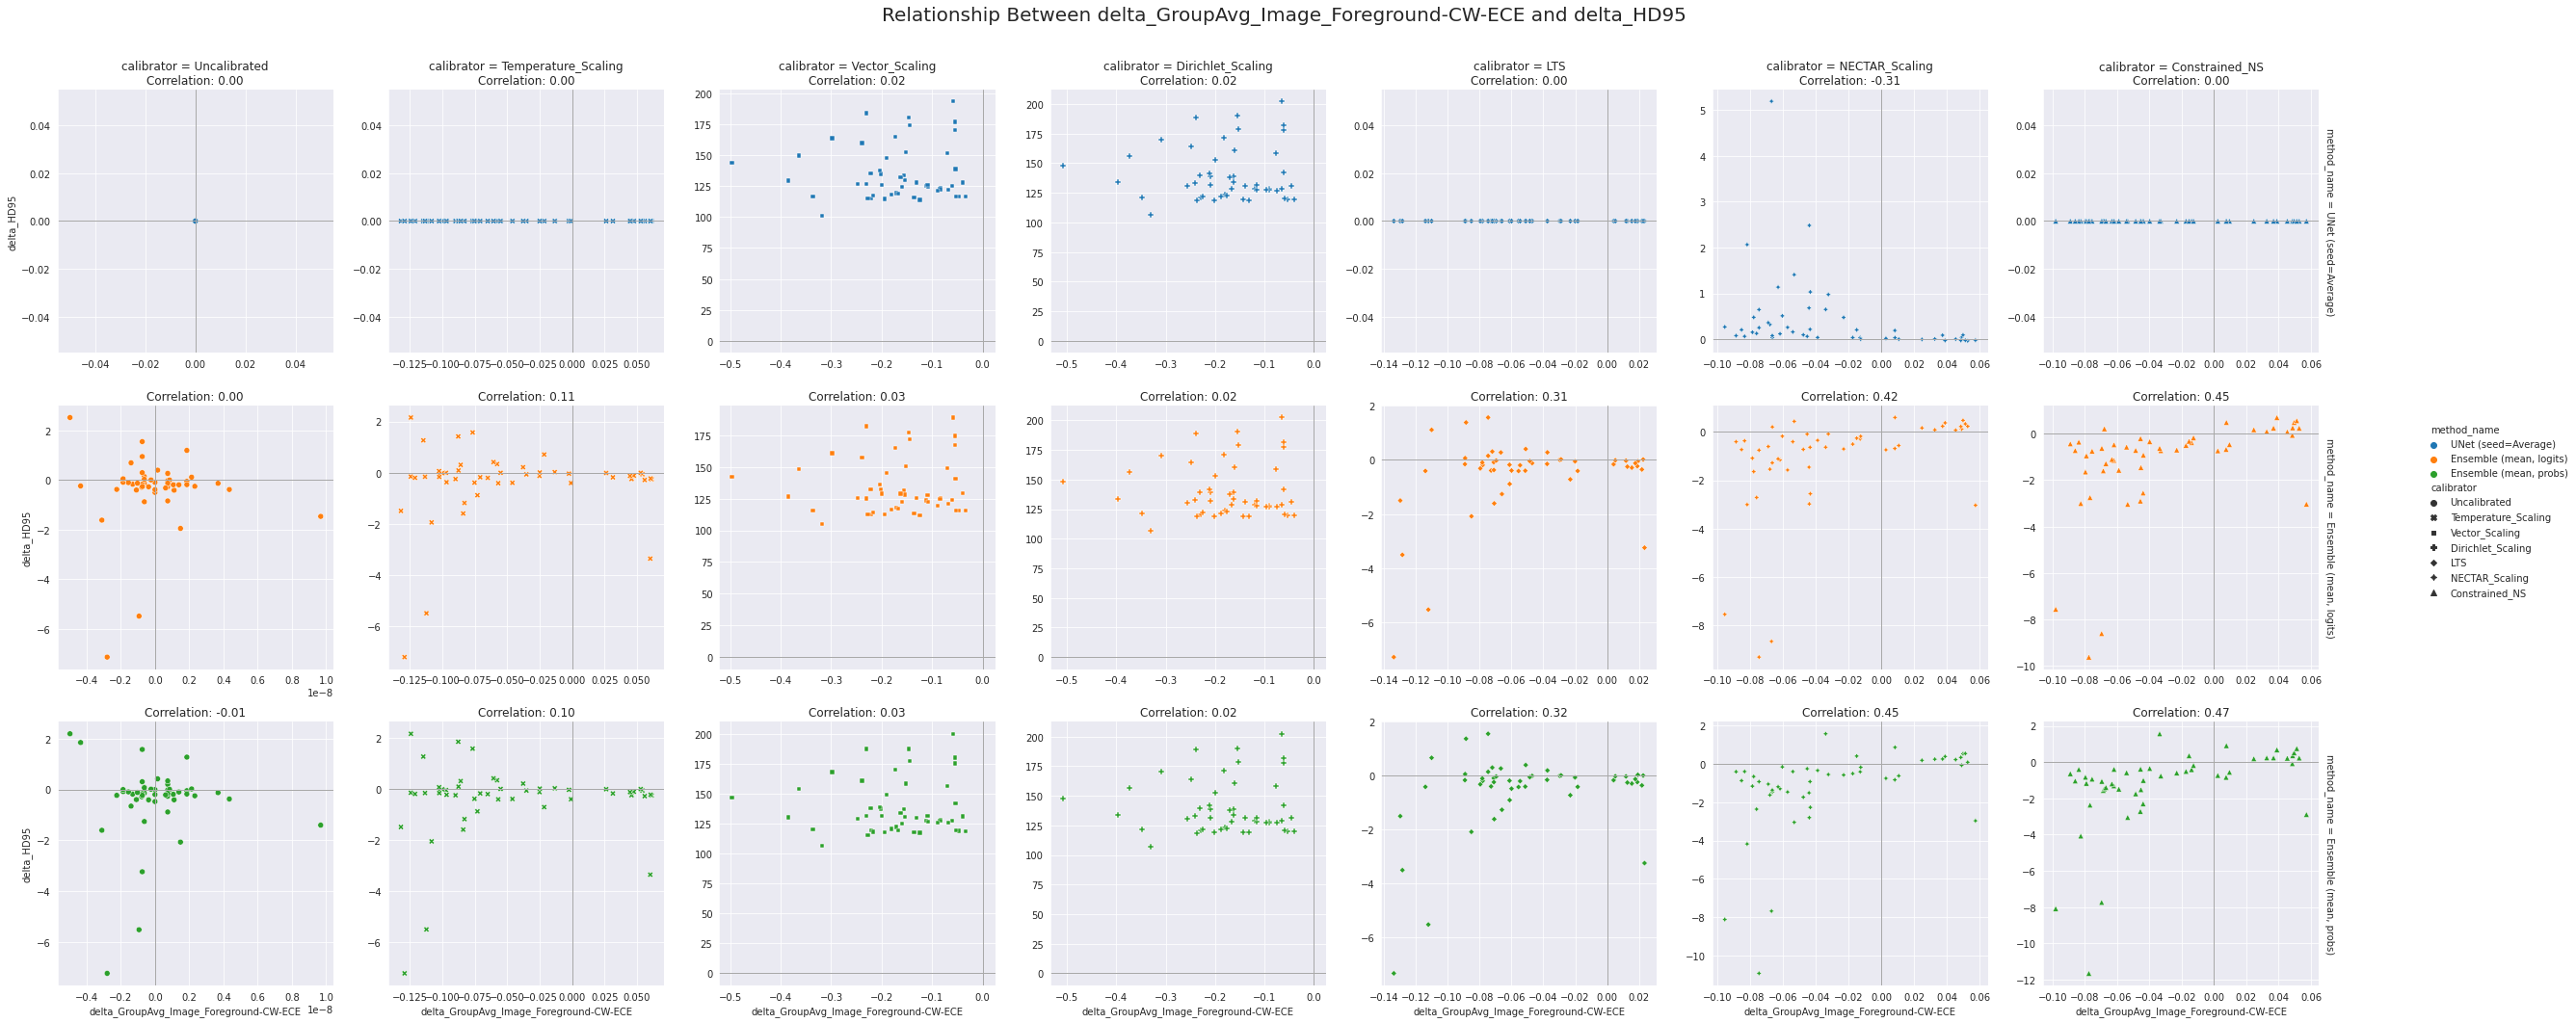

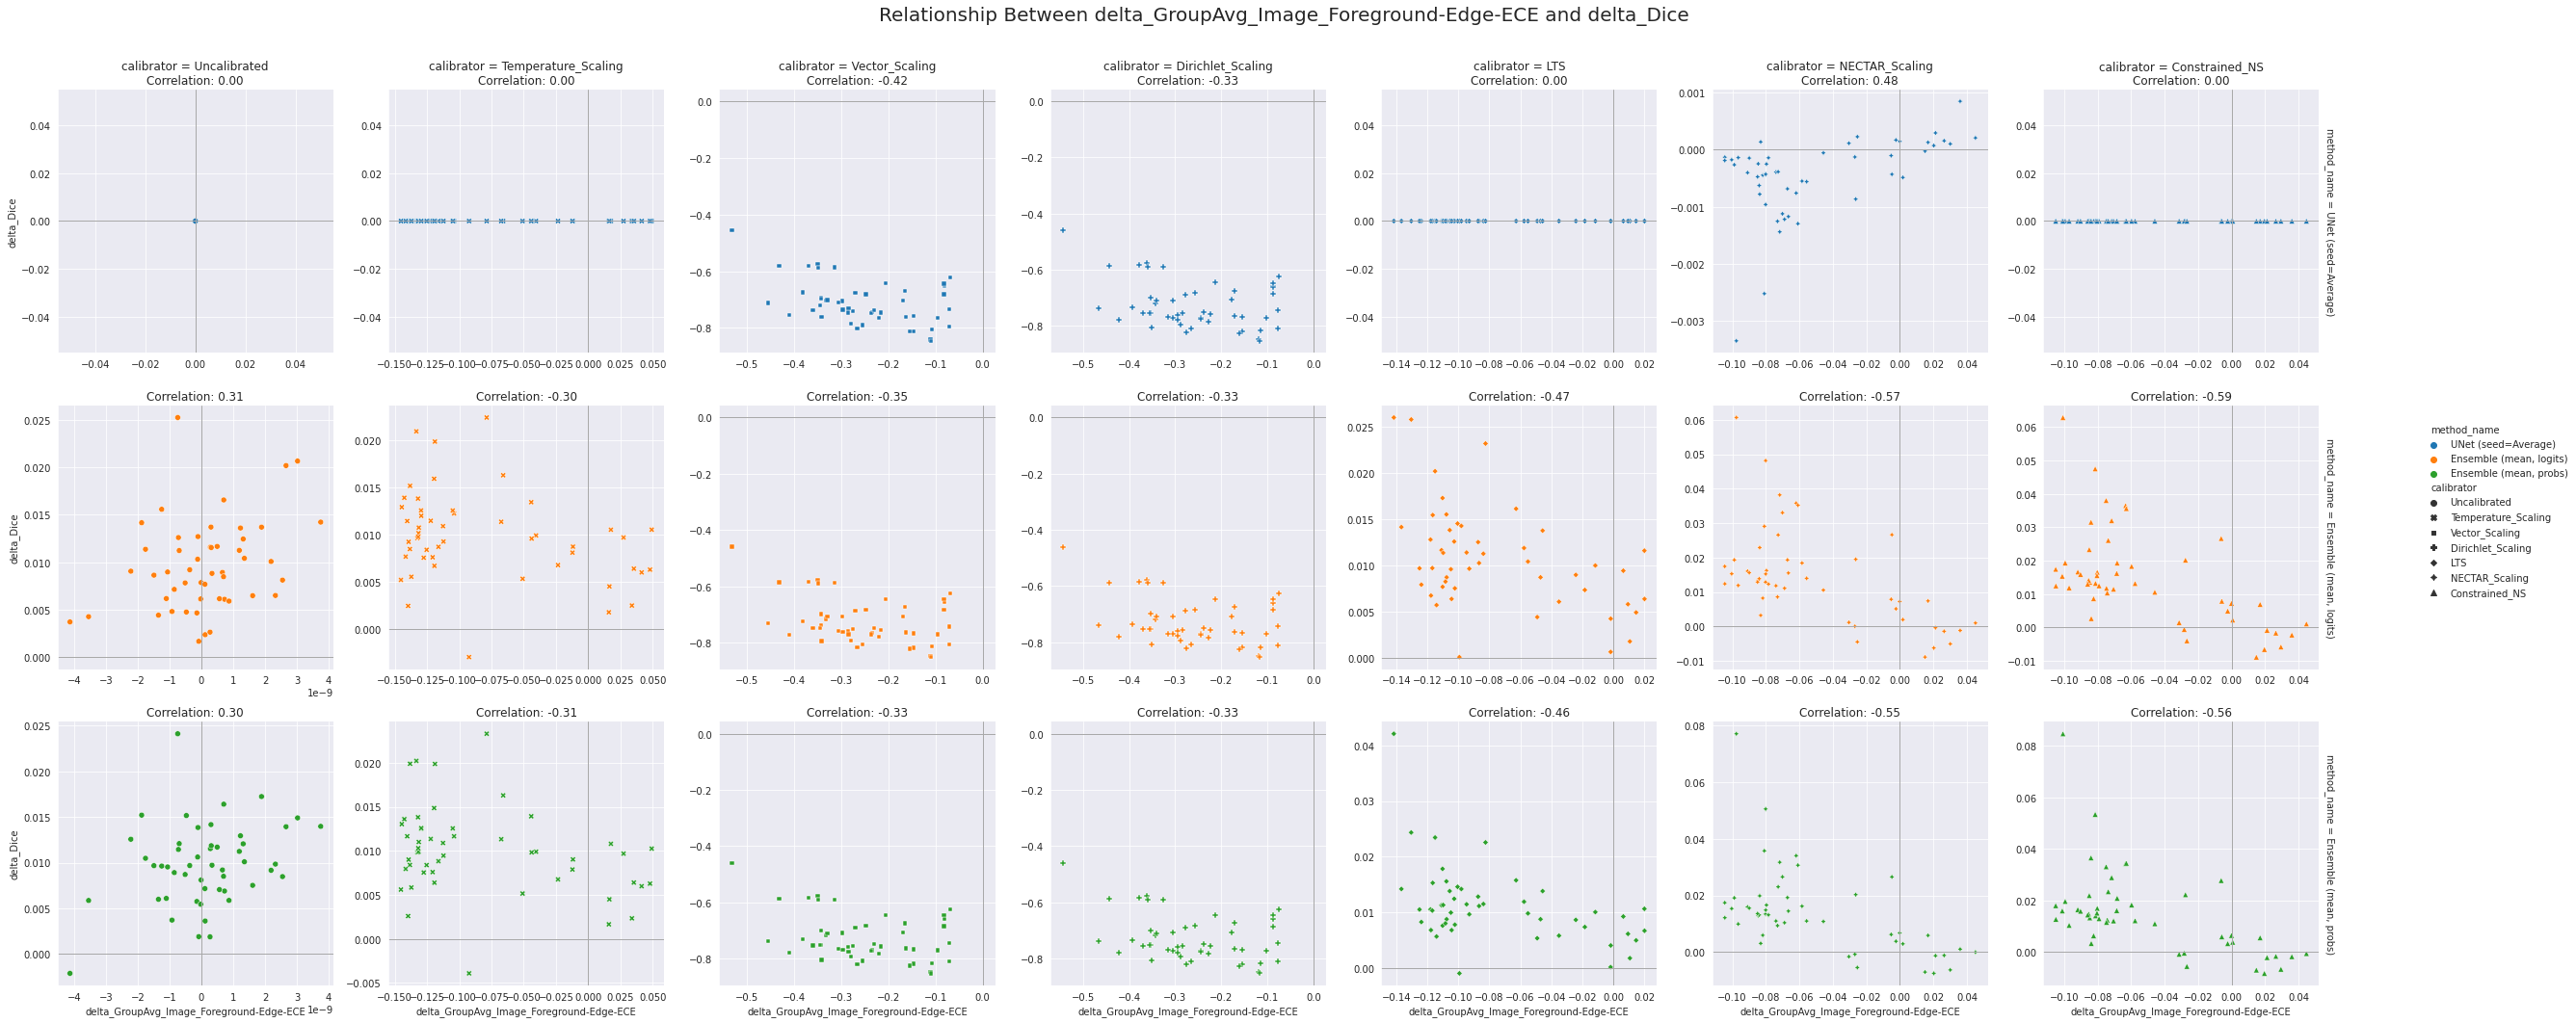

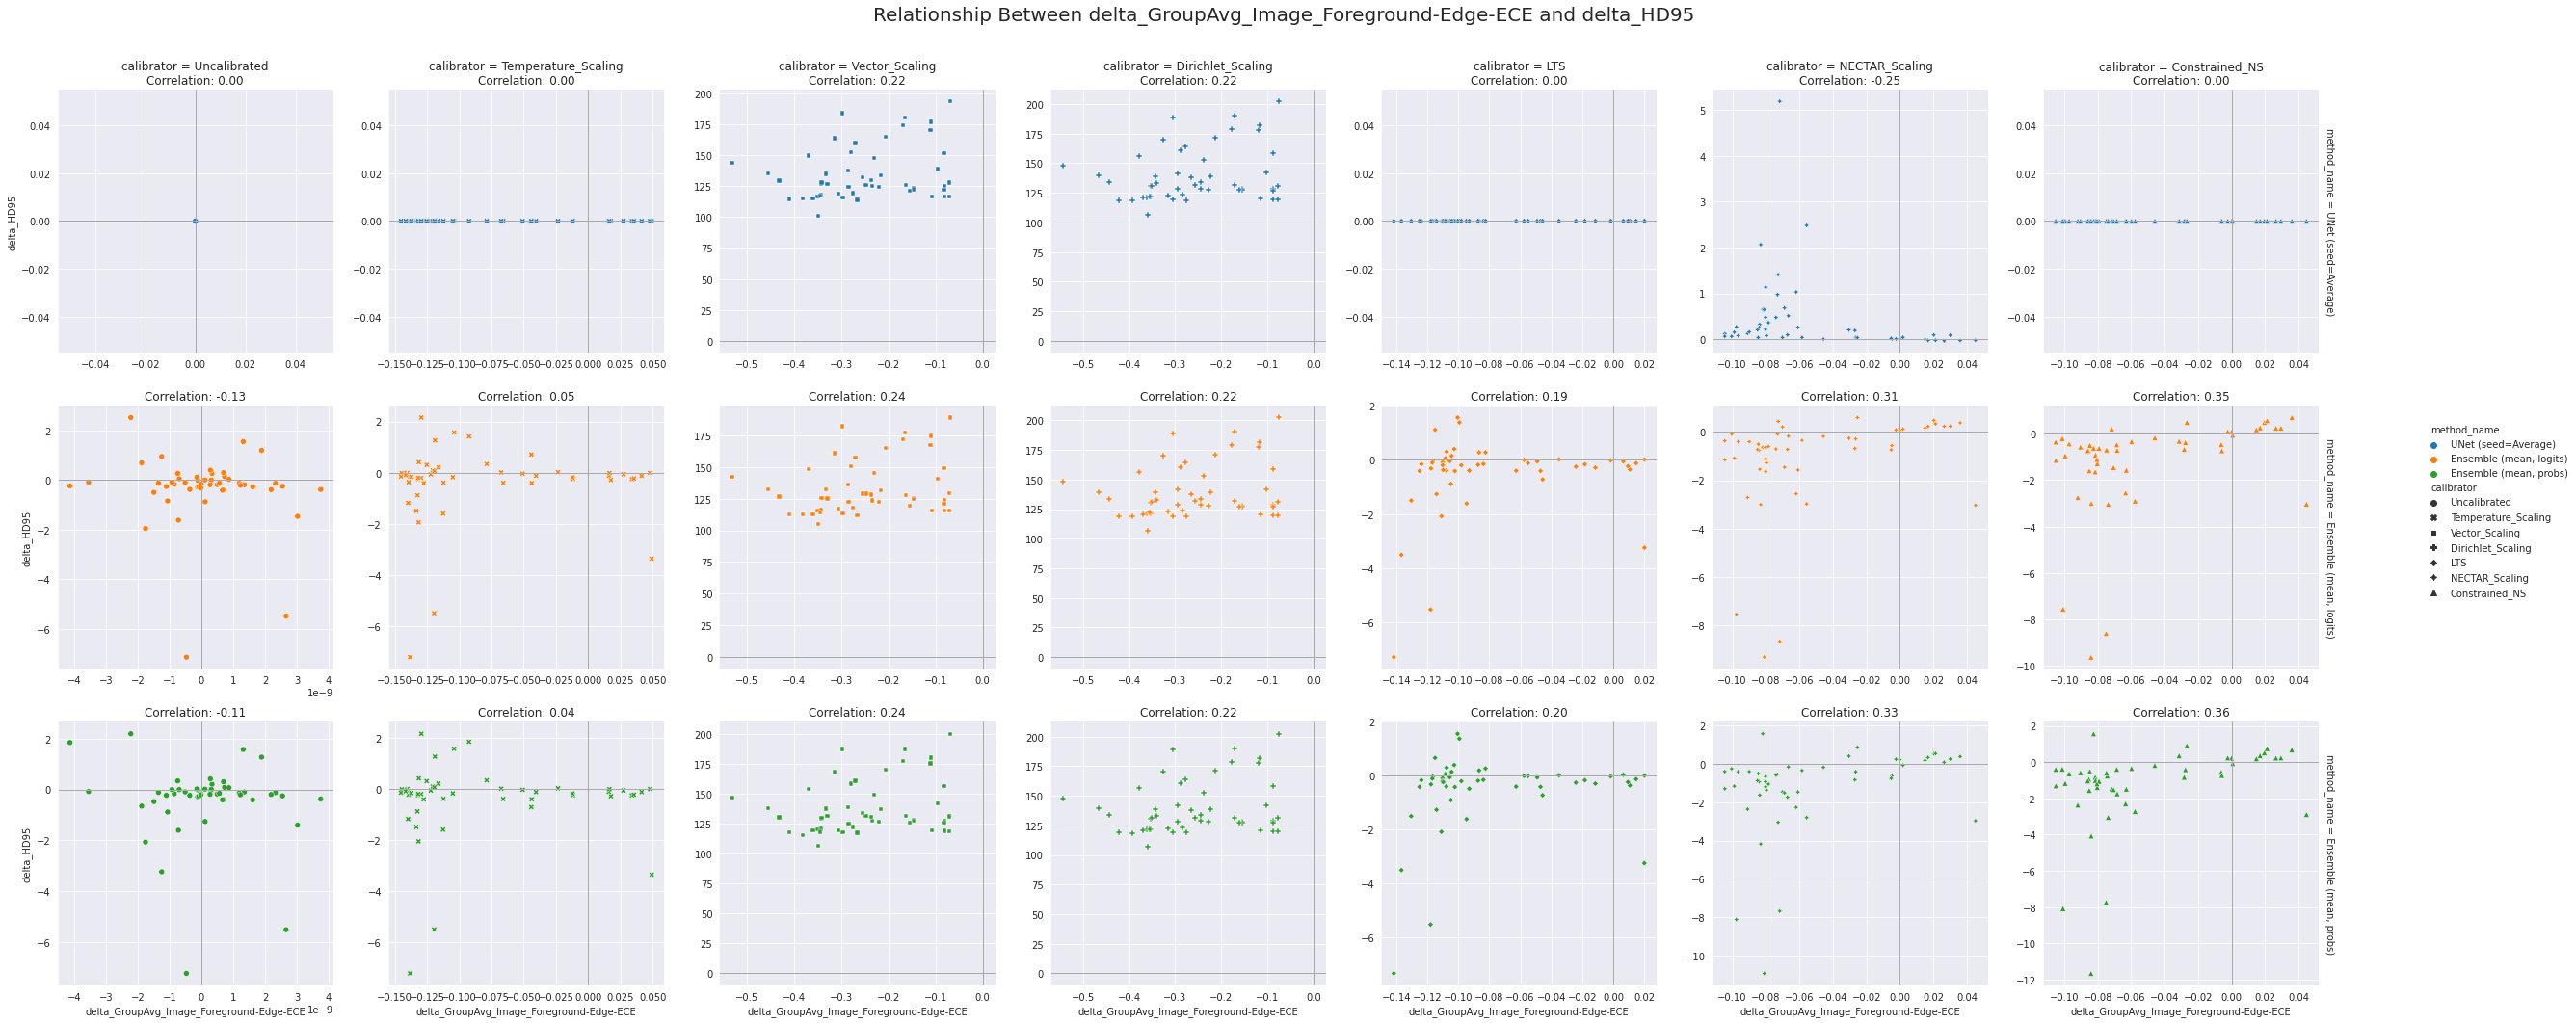

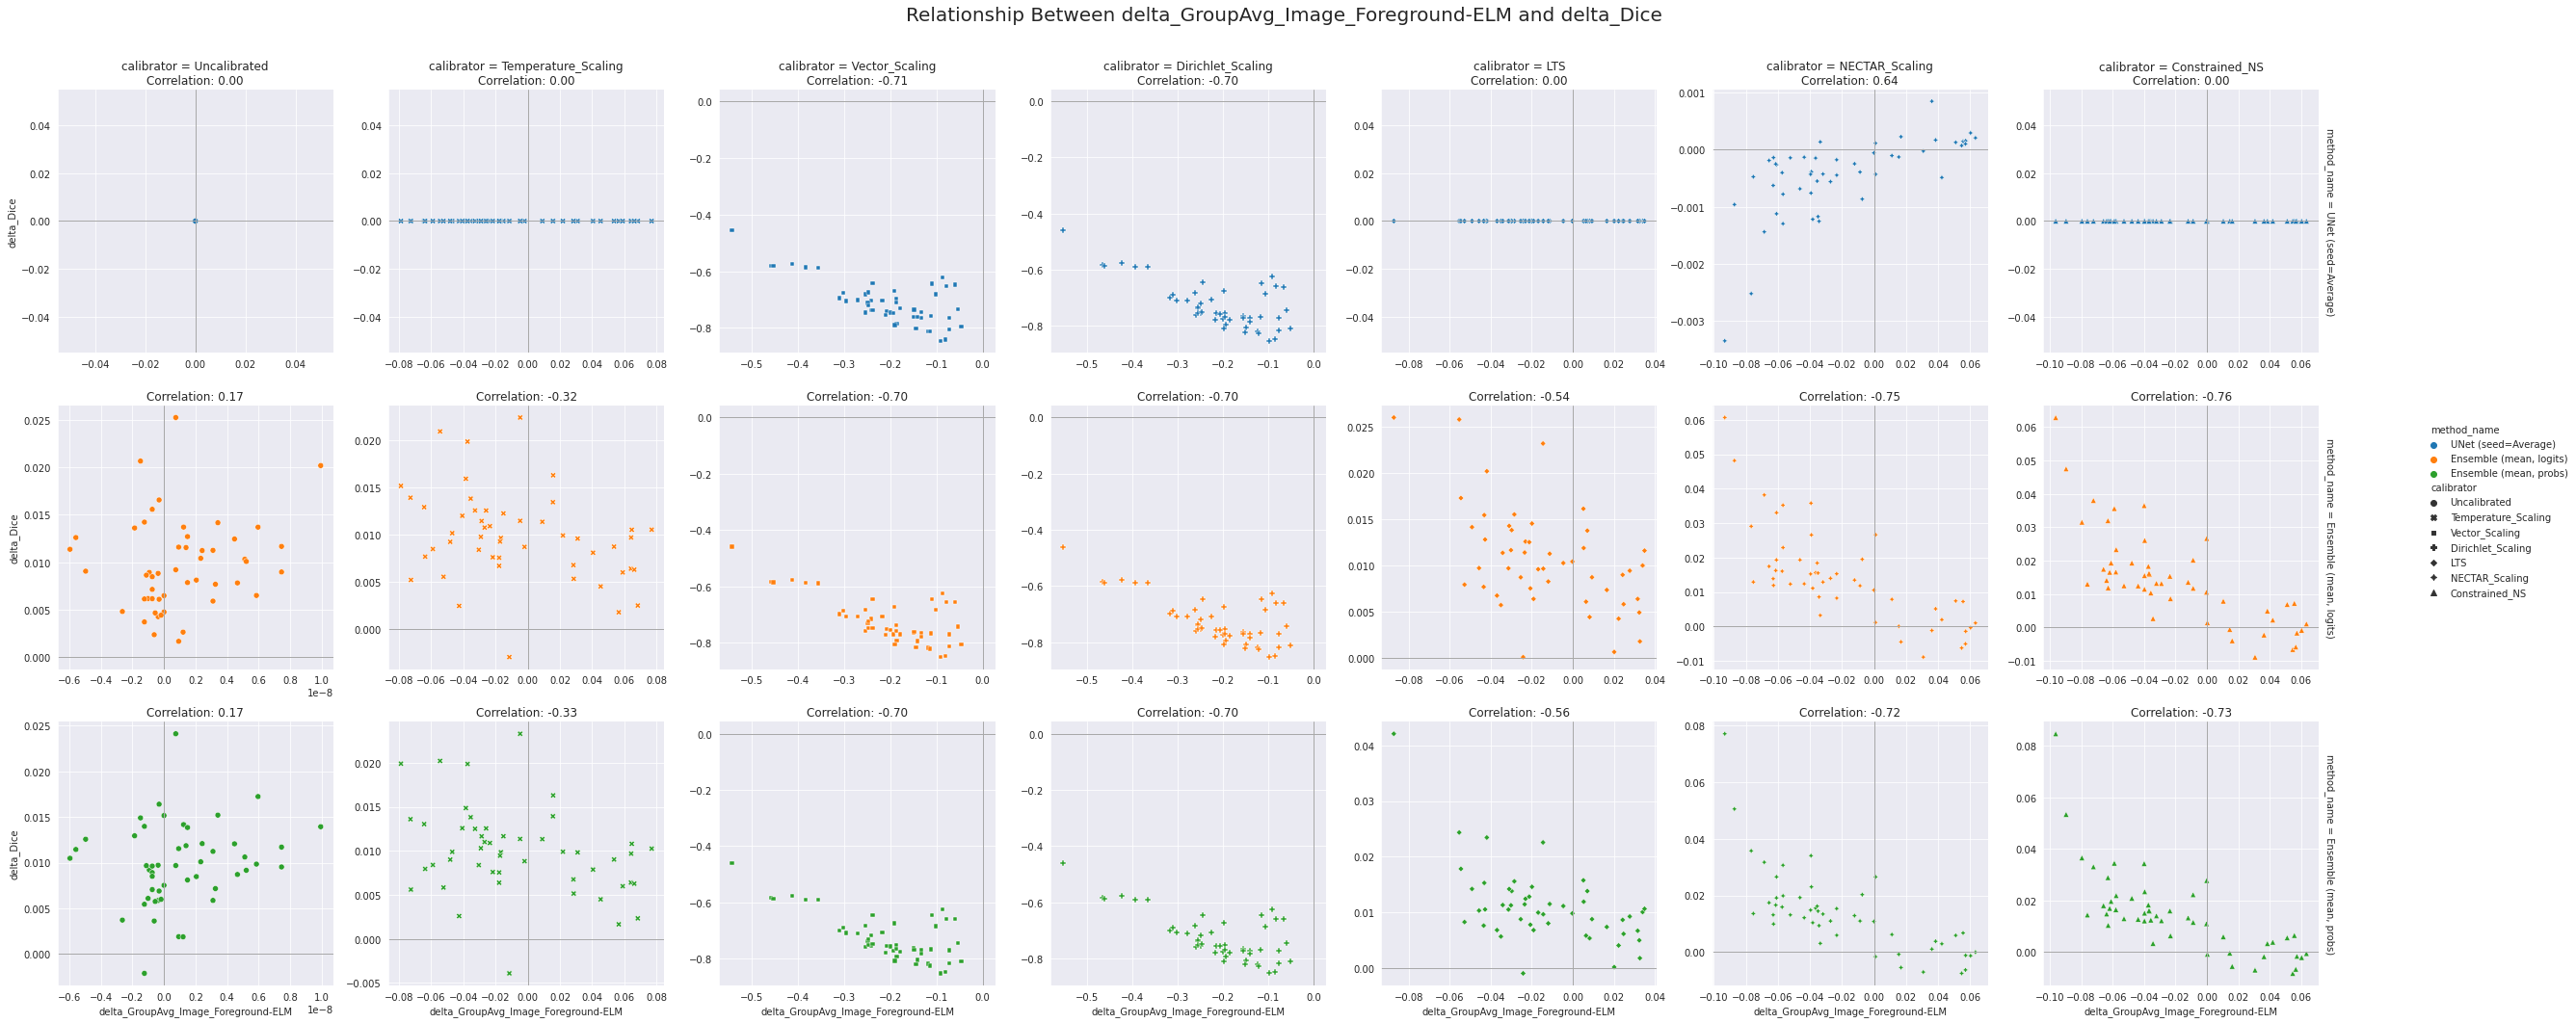

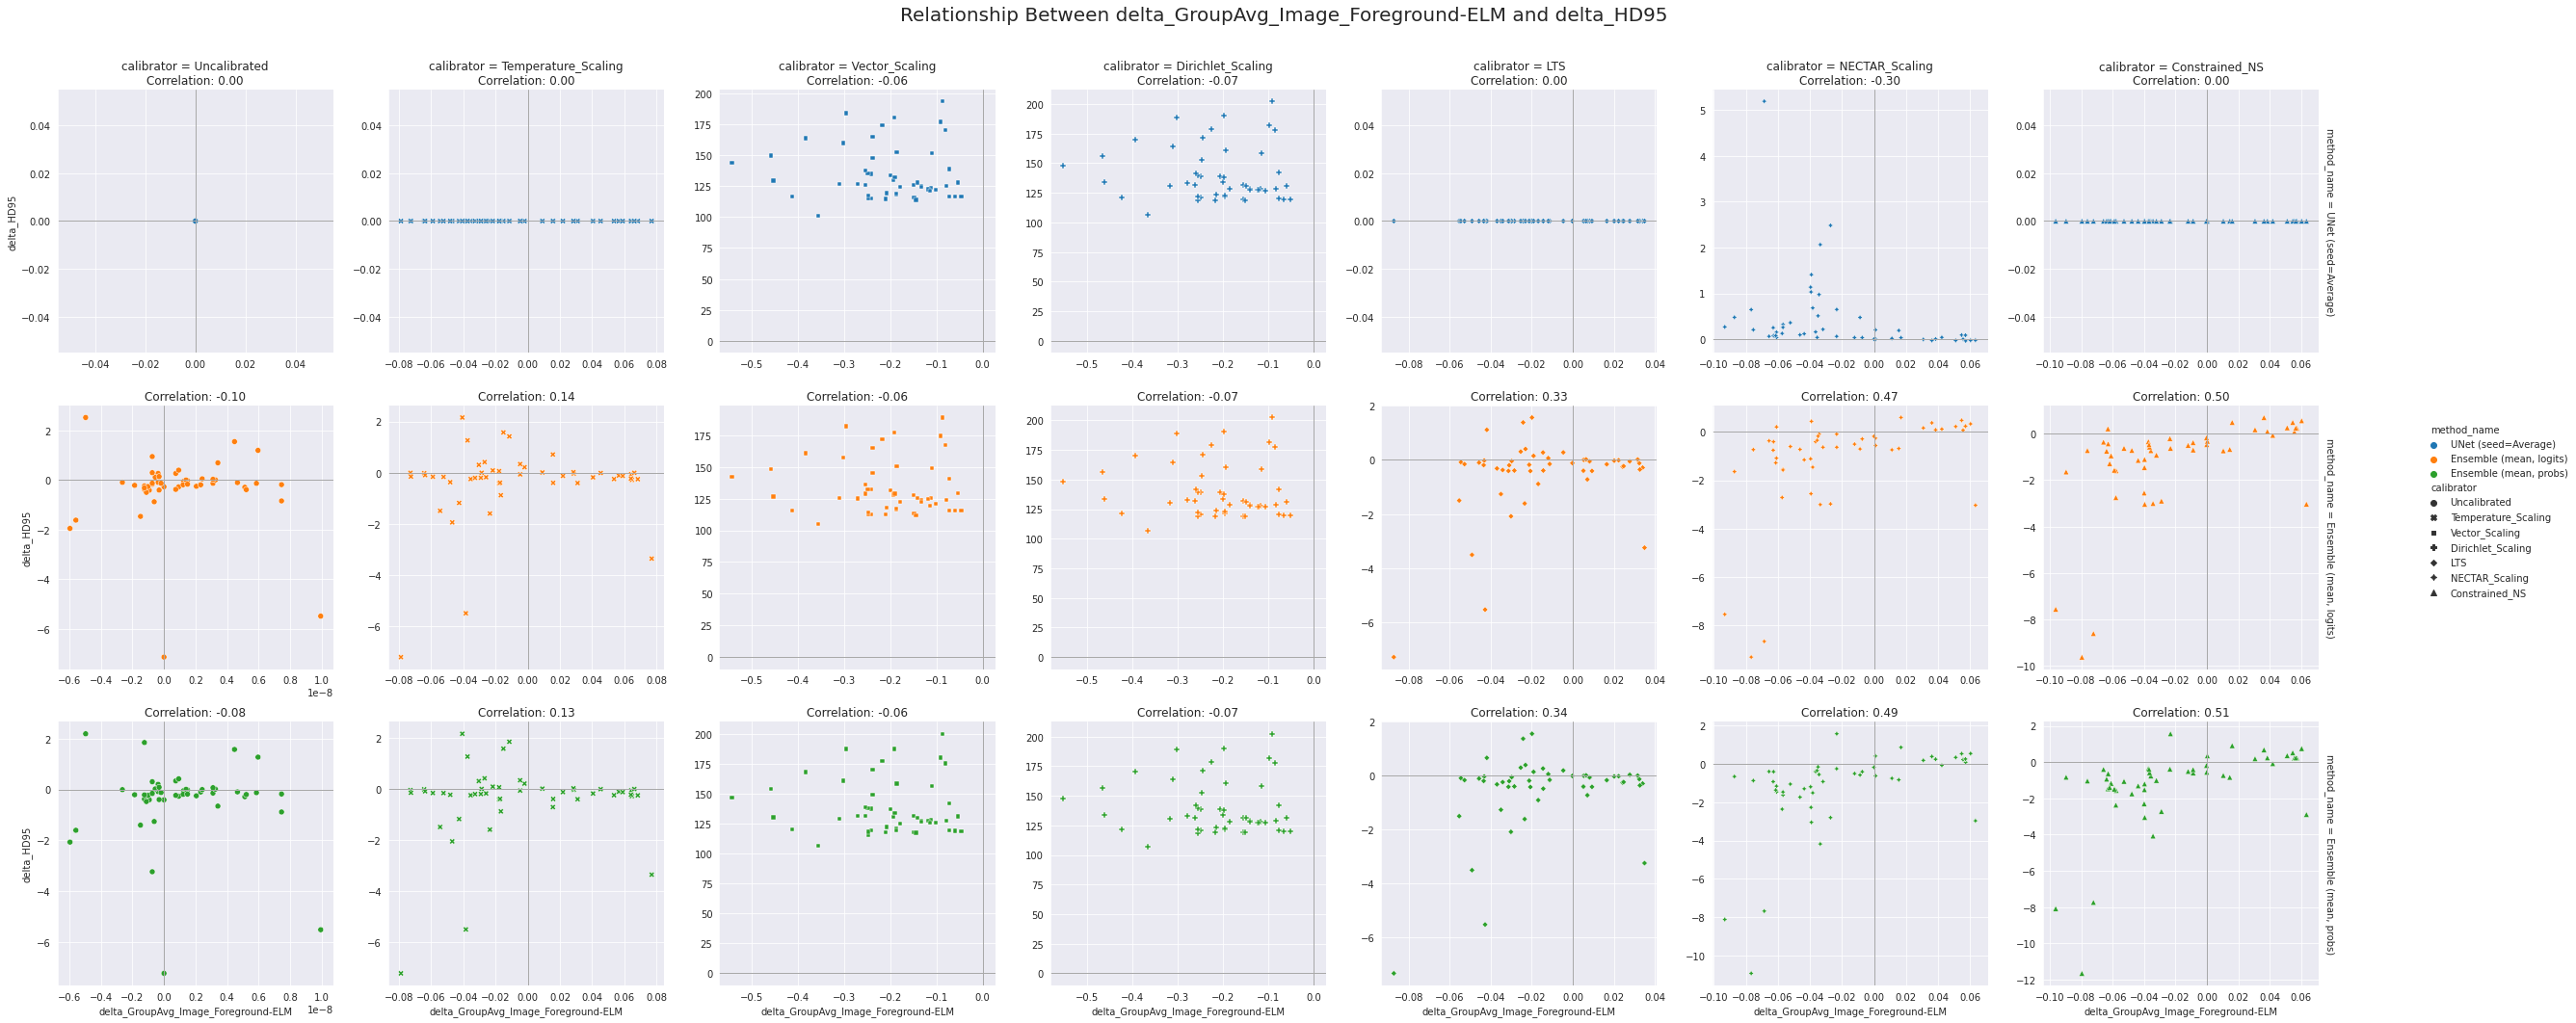

In [21]:
for calibration_metric in ['ECE', 'CW-ECE', 'Edge-ECE', 'ELM']:
    for quality_metric in ['delta_Dice', 'delta_HD95']:
        # for foreground_option in ['', 'Foreground-']:
        for foreground_option in ['Foreground-']:
            # for group_option in ['', 'GroupAvg_']:
            for group_option in ['GroupAvg_']:
                x_metric_name = f'delta_{group_option}Image_{foreground_option}{calibration_metric}'
                y_metric_name = quality_metric 
                # Bin the predictions
                num_bins = 90
                # Gather points into super-points.
                clumped_df = clump_df_datapoints(
                    sorted_perf_df, 
                    num_bins=50, 
                    x='method_name', 
                    y='calibrator',
                    x_metric=x_metric_name,
                    y_metric=y_metric_name
                )
                # Assert that the number of points in the plot is the same
                num_per_config = clumped_df.groupby(['method_name', 'calibrator']).size()
                assert num_per_config.max() == num_per_config.min(),\
                    f"Each subplot should have the same number of datapoints on it, got {num_per_config}."
                # Verify that there are no NaNs in the binned_pivot_per_datapoint for rows of the chosen y metric
                assert clumped_df[y_metric_name].isna().sum() == 0,\
                    f"There should be no NaNs in {y_metric_name} in binned_pivot_per_datapoint, got {clumped_df[y_metric_name]}."
                # Plot the relationship between the two metrics
                plot_method_vs_calibrator_scatterplots(
                    df=clumped_df, 
                    x=x_metric_name, 
                    y=y_metric_name,
                    sharex=False,
                    sharey=False,
                    height=5
                )